## 5.1 Subclassification



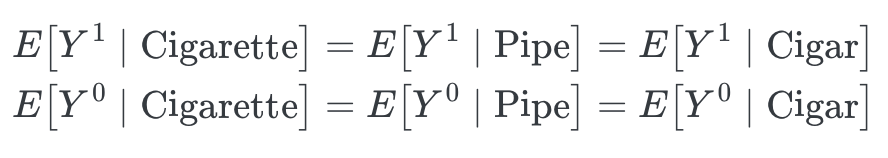


If the mean potential outcomes are the same for each type of smoking category, then wouldn’t we expect the observable characteristics of the smokers themselves to be as well? This connection between the independence assumption and the characteristics of the groups is called **balance**. If the means of the covariates are the same for each group, then we say those covariates are balanced and the two groups are **exchangeable** with respect to those covariates.


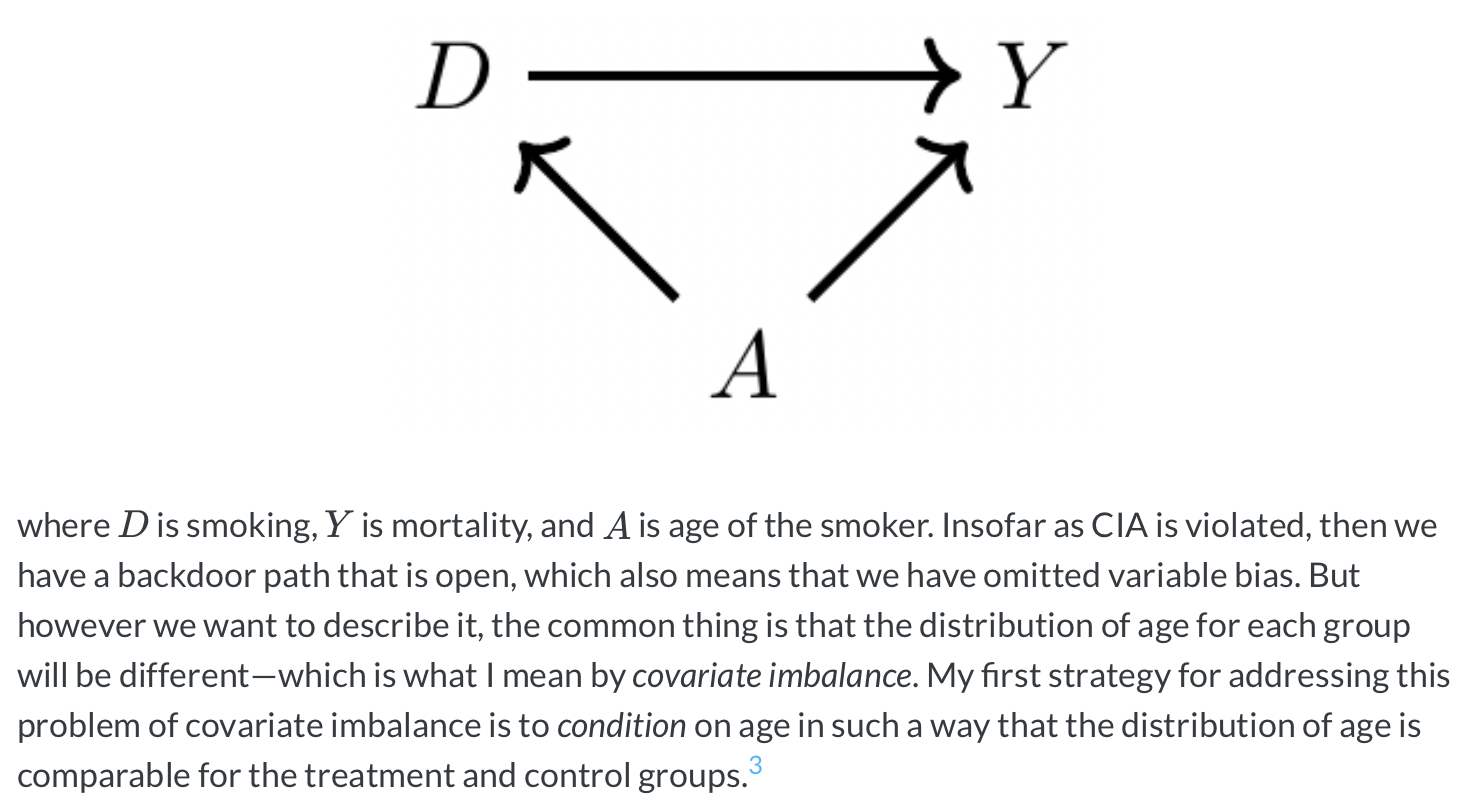

### 5.1.2 assumptions




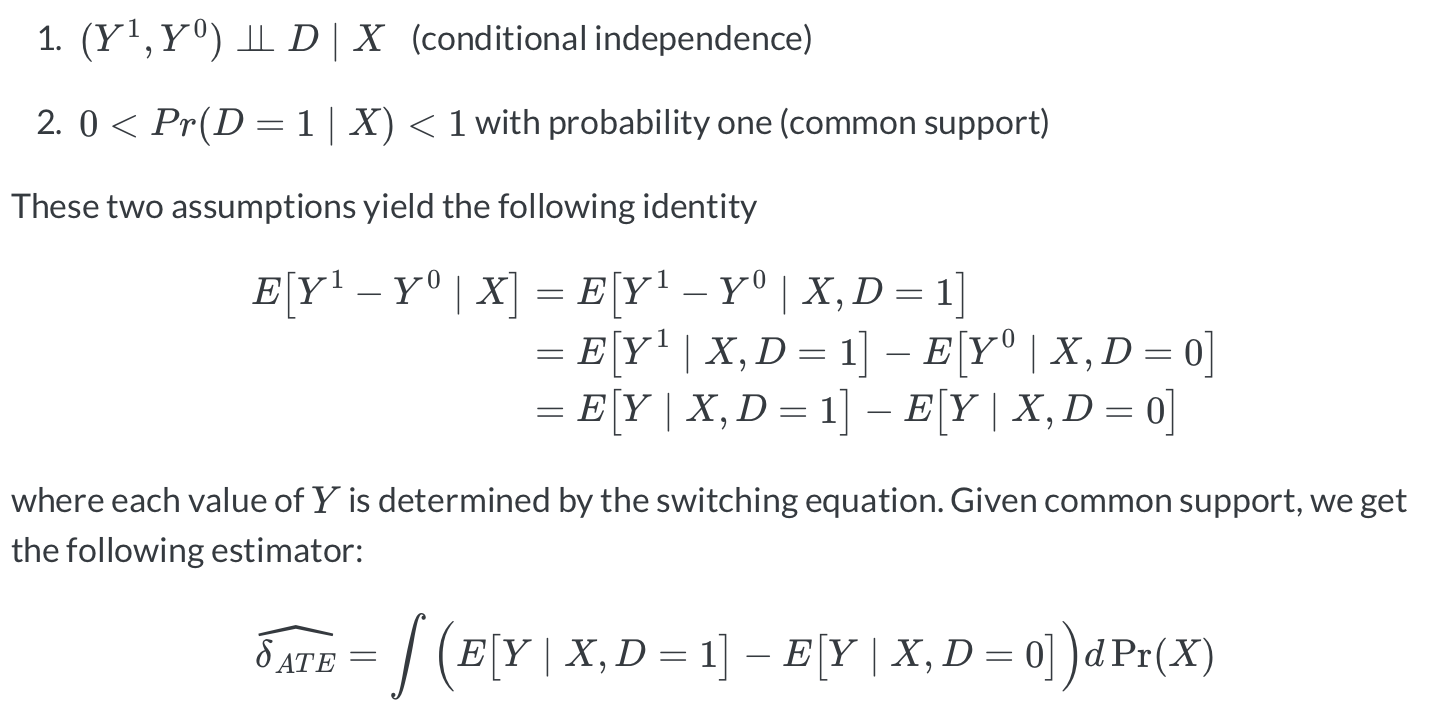

In [1]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import plotnine as p

# read data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
def read_data(file): 
    return pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/" + file)




In [2]:
## Weighted Average Treatment Effect 
titanic = read_data("titanic.dta")

titanic['d'] = 0
titanic.loc[titanic['class']=='1st class', 'd'] = 1

titanic['sex_d'] = 0
titanic.loc[titanic['sex']=='man', 'sex_d'] = 1

titanic['age_d'] = 0
titanic.loc[titanic['age']=='adults', 'age_d'] = 1

titanic['survived_d'] = 0
titanic.loc[titanic['survived']=='yes', 'survived_d'] = 1

#Stratify the data into four groups: young males, young females, old males, old females
titanic['s'] = 0 
titanic.loc[(titanic.sex_d == 0) & (titanic.age_d==1), 's'] = 1
titanic.loc[(titanic.sex_d == 0) & (titanic.age_d==0), 's'] = 2
titanic.loc[(titanic.sex_d == 1) & (titanic.age_d==1), 's'] = 3
titanic.loc[(titanic.sex_d == 1) & (titanic.age_d==0), 's'] = 4

obs = titanic.loc[titanic.d == 0].shape[0]



In [3]:
def weighted_avg_effect(df):
    #Calculate the difference in survival probabilities for each group.
    diff = df[df.d==1].survived_d.mean() - df[df.d==0].survived_d.mean()
    #Calculate the number of people in the non-first-class groups and 
    #divide by the total number of non-first-class population. 
    #These are our strata-specific weights.
    weight = df[df.d==0].shape[0]/obs
    return diff*weight

#Calculate the weighted average survival rate using the strata weights
wate = titanic.groupby('s').apply(weighted_avg_effect).sum()

print("The weigthted average treatment effect estimate is {:.2%}".format(wate))

The weigthted average treatment effect estimate is 18.88%


### 5.1.4 curse of dimensionality


once we condition on individual age and gender, it’s entirely likely that we will not have the information necessary to calculate differences within strata, and therefore be unable to calculate the strata-specific weights that we need for subclassification.

The problem is that our stratifying variable has too many dimensions, and as a result, we have **sparseness** in some cells because the sample is too small.

But long as there exist controls for a given treatment strata, we can calculate the ATT. The equation to do so can be compactly written as:
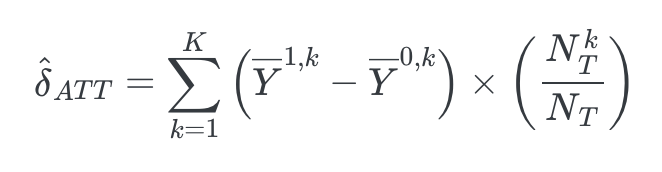

In this small sample, we probably will end up with many cells having missing information. This is called *the curse of dimensionality*. If sparseness occurs, it means many cells may contain either only treatment units or only control units, but not both. If that happens, we can’t use subclassification, because we do not have common support. 





## 5.2 Exact Matching

if we filled in the missing potential outcome for each treatment unit using a control group unit that was “closest” to the treatment group unit for some  confounder? This would give us estimates of all the counterfactuals from which we could simply take the average over the differences. As we will show, this will also achieve covariate balance. This method is called **matching**.

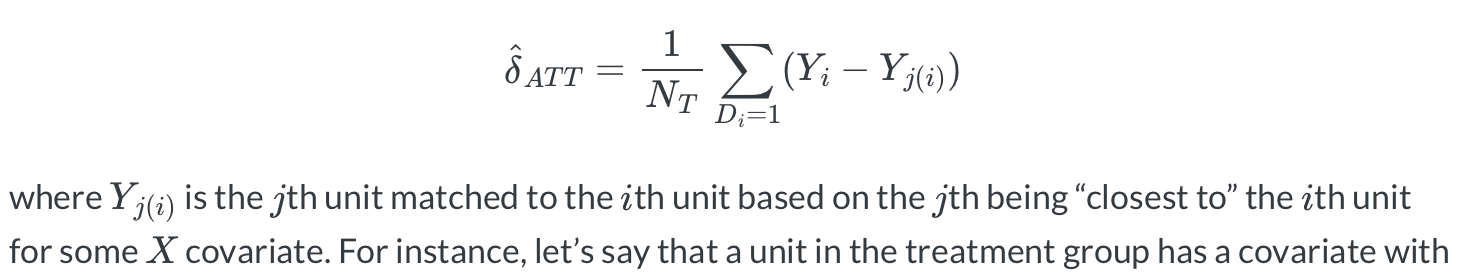

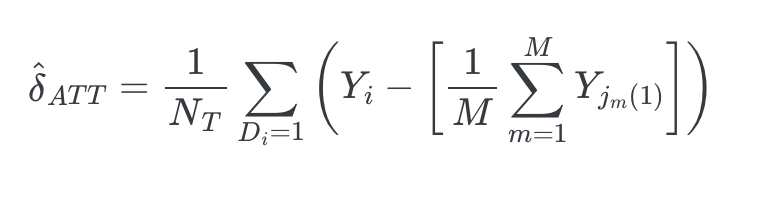
this one averages over several close matches as opposed to just picking one. 

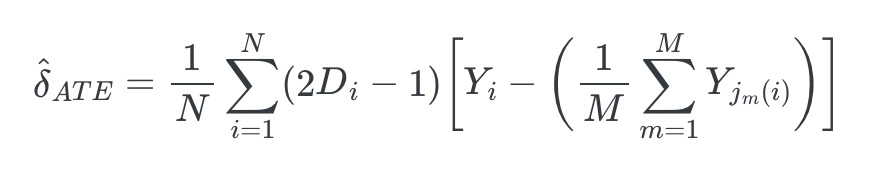

# Bias Correction

In [1]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import plotnine as p

# read data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
def read_data(file): 
    return pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/" + file)


In [11]:
training_bias_reduction = read_data("training_bias_reduction.dta")

training_bias_reduction['Y1'] = 0
training_bias_reduction.loc[training_bias_reduction['Unit'].isin(range(1,5)), 'Y1'] = training_bias_reduction['Y']
training_bias_reduction['Y0'] = (4,0,5,1,4,0,5,1)

In [12]:
training_bias_reduction

,Unit,Y,D,X,Y1,Y0
0,1,5,1,11,5,4
1,2,2,1,7,2,0
2,3,10,1,5,10,5
3,4,6,1,3,6,1
4,5,4,0,10,0,4
5,6,0,0,8,0,0
6,7,5,0,4,0,5
7,8,1,0,1,0,1


In [14]:
train_reg = sm.OLS.from_formula('Y ~ X', training_bias_reduction).fit()
train_reg.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.163
Method:                 Least Squares   F-statistic:                   0.01702
Date:                Thu, 11 Jul 2024   Prob (F-statistic):              0.900
Time:                        21:13:44   Log-Likelihood:                -20.066
No. Observations:                   8   AIC:                             44.13
Df Residuals:                       6   BIC:                             44.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4227      2.584      1.711      0.138      -1.901      10.746
X             -0.0486      0.373     -0.130      0.900      -0.960       0.863
==============================================================================
Omnibus:                        0.718   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.698   Jarque-Bera (JB):                0.328
Skew:                           0.433   Prob(JB):                        0.849
Kurtosis:                       2.517   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
training_bias_reduction['u_hat0'] = train_reg.predict(training_bias_reduction)
training_bias_reduction = training_bias_reduction[['Unit', 'Y1', 'Y0', 'Y', 'D', 'X', 'u_hat0']]

training_bias_reduction

,Unit,Y1,Y0,Y,D,X,u_hat0
0,1,5,4,5,1,11,3.888071
1,2,2,0,2,1,7,4.082474
2,3,10,5,10,1,5,4.179676
3,4,6,1,6,1,3,4.276878
4,5,0,4,4,0,10,3.936672
5,6,0,0,0,0,8,4.033873
6,7,0,5,5,0,4,4.228277
7,8,0,1,1,0,1,4.374080


# Propensity Score Methods: NSW job training program

In [18]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import plotnine as p

# read data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
def read_data(file): 
    return pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/" + file)


nsw_dw = read_data('nsw_mixtape.dta')
nsw_dw

,data_id,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000000,0.000000,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000000,0.000000,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000000,0.000000,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000000,0.000000,289.789886
...,...,...,...,...,...,...,...,...,...,...,...
440,Dehejia-Wahba Sample,0.0,21.0,9.0,1.0,0.0,0.0,1.0,31886.429688,12357.219727,0.000000
441,Dehejia-Wahba Sample,0.0,28.0,11.0,1.0,0.0,0.0,1.0,17491.449219,13371.250000,0.000000
442,Dehejia-Wahba Sample,0.0,29.0,9.0,0.0,1.0,0.0,1.0,9594.307617,16341.160156,16900.300781
443,Dehejia-Wahba Sample,0.0,25.0,9.0,1.0,0.0,1.0,1.0,24731.619141,16946.630859,7343.963867


### ATE calculation

In [20]:
mean1 = nsw_dw[nsw_dw.treat==1].re78.mean()
mean0 = nsw_dw[nsw_dw.treat==0].re78.mean()
ate = np.unique(mean1 - mean0)[0]

print("The experimental ATE estimate is {:.2f}".format(ate))

The experimental ATE estimate is 1794.34


### CPS data

In [23]:
# Prepare data for logit 
nsw_dw_cpscontrol = read_data('cps_mixtape.dta')
nsw_dw_cpscontrol

,data_id,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
0,CPS1,0,45,11,0,0,1,1,21516.669922,25243.550781,25564.669922
1,CPS1,0,21,14,0,0,0,0,3175.970947,5852.564941,13496.080078
2,CPS1,0,38,12,0,0,1,0,23039.019531,25130.759766,25564.669922
3,CPS1,0,48,6,0,0,1,1,24994.369141,25243.550781,25564.669922
4,CPS1,0,18,8,0,0,1,1,1669.295044,10727.610352,9860.869141
...,...,...,...,...,...,...,...,...,...,...,...
15987,CPS1,0,22,12,1,0,0,0,3975.352051,6801.435059,2757.437988
15988,CPS1,0,20,12,1,0,1,0,1445.938965,11832.240234,6895.071777
15989,CPS1,0,37,12,0,0,0,0,1733.951050,1559.370972,4221.865234
15990,CPS1,0,47,9,0,0,1,1,16914.349609,11384.660156,13671.929688


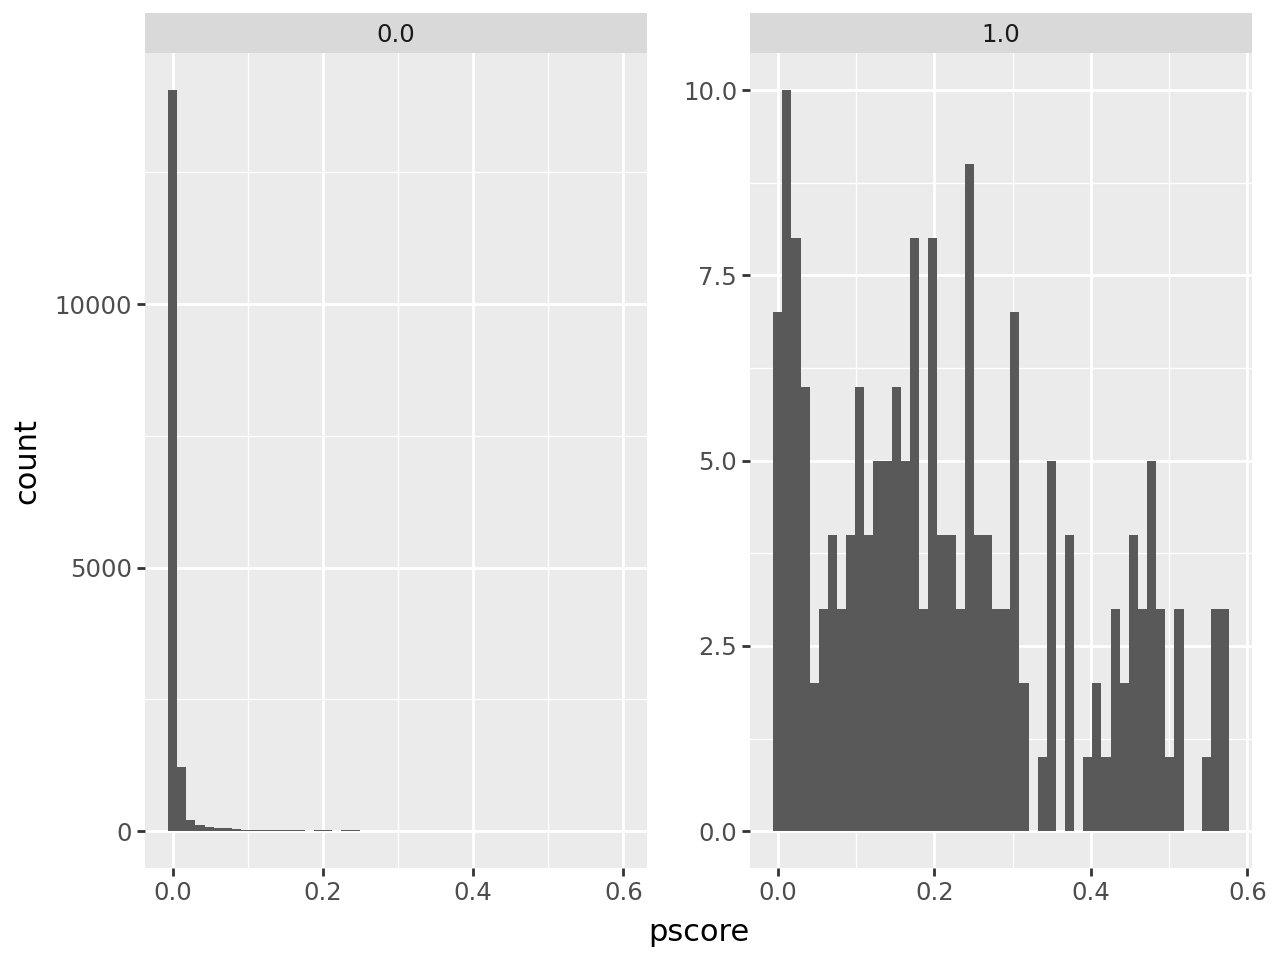

In [24]:
# Prepare data for logit 

nsw_dw_cpscontrol = pd.concat((nsw_dw_cpscontrol, nsw_dw))
nsw_dw_cpscontrol['u74'], nsw_dw_cpscontrol['u75'] = 0, 0
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re74==0, 'u74'] = 1
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re75==0, 'u75'] = 1
# estimating propensity score
logit_nsw = smf.glm(formula="""treat ~ age + I(age**2) + I(age**3) + educ + I(educ**2) + 
                    marr + nodegree + black + hisp + re74 + re75 + u74 + u75 + educ*re74""", 
                    family=sm.families.Binomial(),
                   data=nsw_dw_cpscontrol).fit()
                  
nsw_dw_cpscontrol['pscore'] = logit_nsw.predict(nsw_dw_cpscontrol)

nsw_dw_cpscontrol.groupby('treat')['pscore'].mean()

p.ggplot(nsw_dw_cpscontrol, p.aes(x='pscore')) +    p.geom_histogram(bins=50) +    p.facet_wrap("treat", scales='free')